In [1]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization

import imgkit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

import xgboost
import shap

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [3]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [4]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data.head()

(128800, 4)


,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,141.486033,99.346299
1,1,2 irrad @ 4 Gy,52.792768,99.346299
2,1,1 non irrad,96.082838,99.346299
3,1,2 irrad @ 4 Gy,100.306259,99.346299
4,1,1 non irrad,69.687151,99.346299


## Train/test split 

In [70]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [71]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [119]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [120]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## Random GridSearch for pipeline/model params

In [10]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [11]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [12]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [13]:
# bayesian optimized model
# bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
#                        objective ='reg:squarederror', random_state=0, subsample=.9,
#                        gamma=1.7)

## Visualizing model objective

In [121]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


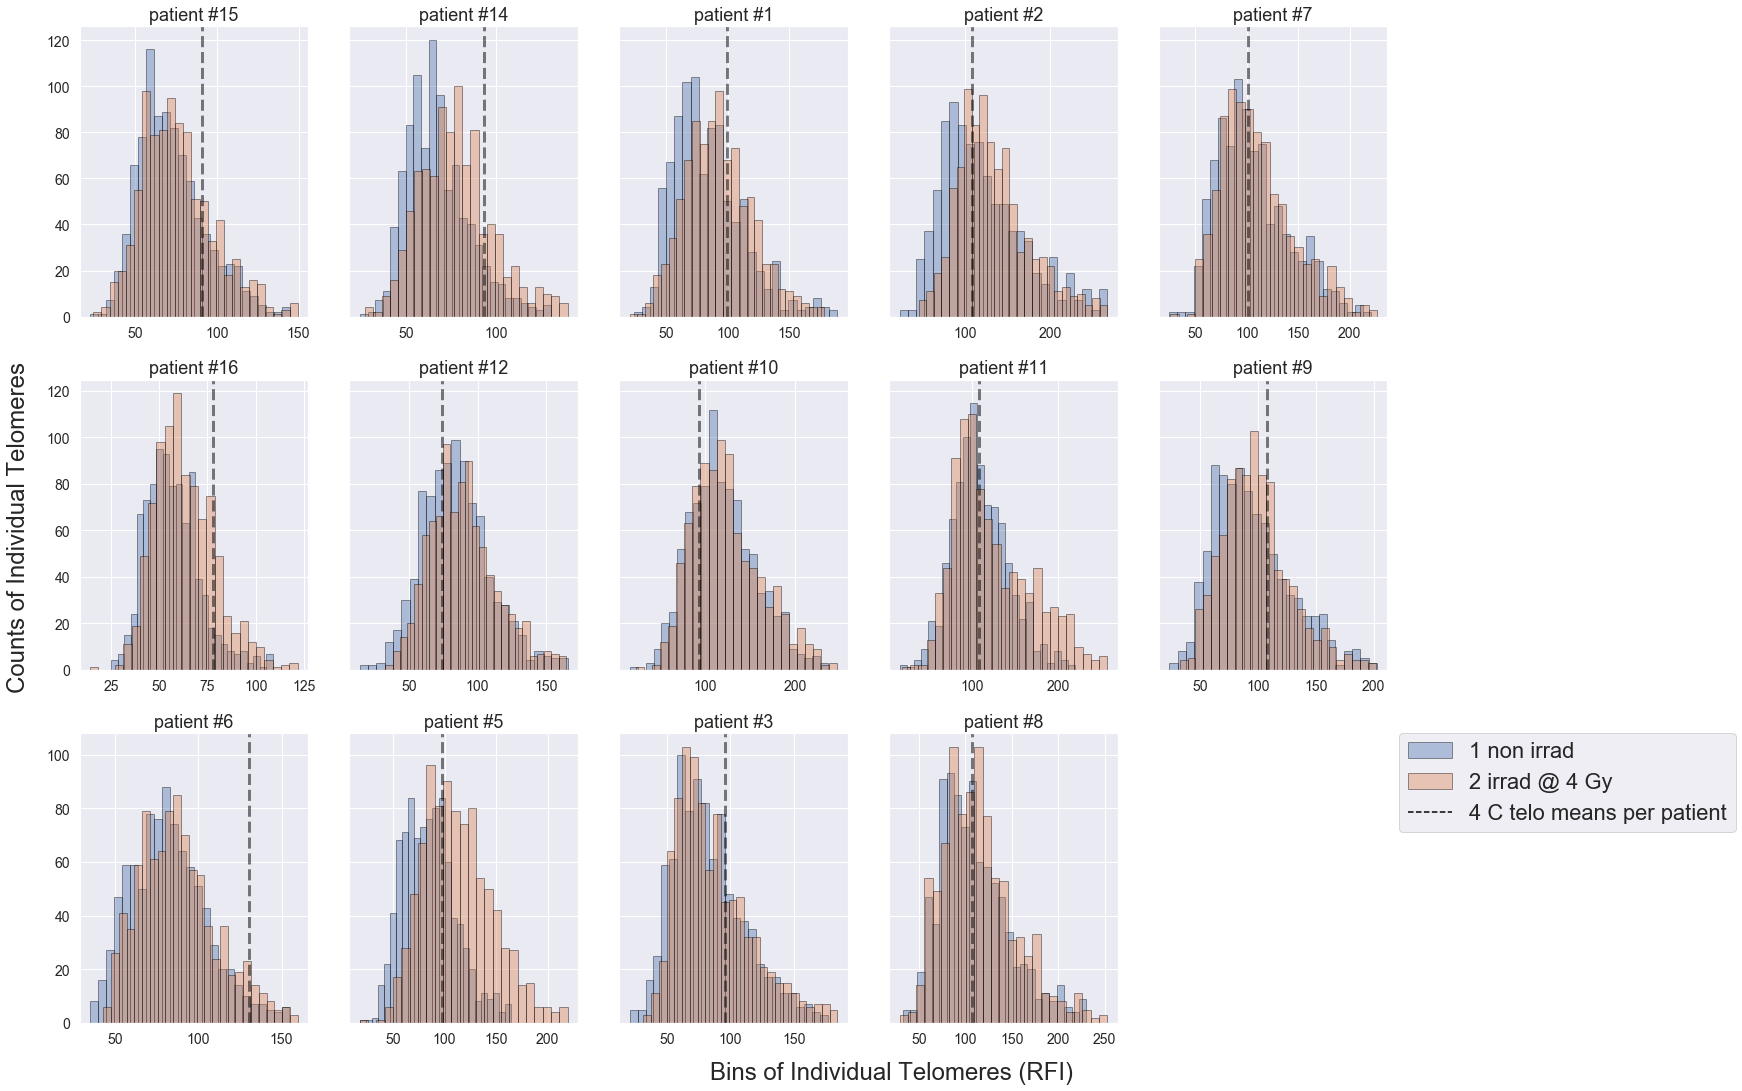

In [79]:
trp.plot_individ_telos_ML_objective(df=test_set, target='4 C telo means')

## Cross validation; MAE & R2 score 

In [117]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.11976835 3.22337912 3.16388752 3.19300705 3.33537381] 

MEAN of MAE all folds: 3.2070831694395614
STD of MAE all folds: 0.07268002019407328

MAE of predict_y_test & y_test: 3.1521050265343127
R2 between predict_y_test & y_test: 0.8864049095637849


In [111]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_xgb_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 2.927325306285535
R2 predicted vs. actual 4 C telo means: 0.93057101893561


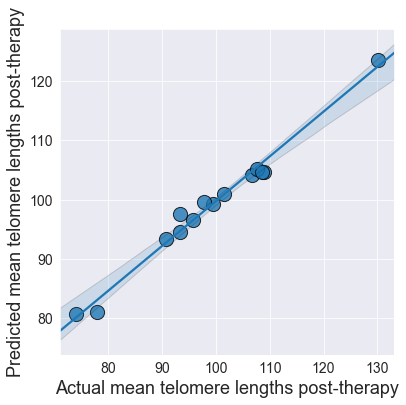

In [112]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 1', fontsize=22, weight='bold')
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C mean telos vs predicted.png', 
            dpi=400)

## Dataframe for model metrics

In [74]:
stats_df = trp.make_stats_df(stats_list=telo_row)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2097,0.0578,3.1677,0.8922


In [75]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | features_individ telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Model interpretability

In [107]:
X,y = shap.datasets.boston()

In [126]:
test_clean.head()

,individual telomeres,4 C telo means,timepoint_2 irrad @ 4 Gy
0,43.690333,90.680352,1
1,54.546846,93.279099,0
2,52.527118,93.279099,0
3,77.077441,99.346299,0
4,51.135814,108.915327,0


In [128]:
shap.initjs()

X = test_clean.drop('4 C telo means', axis=1)

# # explain the model's predictions using SHAP
explainer = shap.TreeExplainer(fit_xgb_model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


## Testing if linear regression can predict 4C mean telos using individual telos

In [61]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [62]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

MAE per CV fold: 
[9.53272358 9.55717311 9.46156818 9.59405717 9.4419712 ] 

MEAN of MAE all folds: 9.517498648052406
STD of MAE all folds: 0.05744507218426119

MAE of predict_y_test & y_test: 9.502907562949988
R2 between predict_y_test & y_test: 0.04628528088278183


In [63]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 9.273615737872925
R2 predicted vs. actual 4 C telo means: 0.07772479439764501


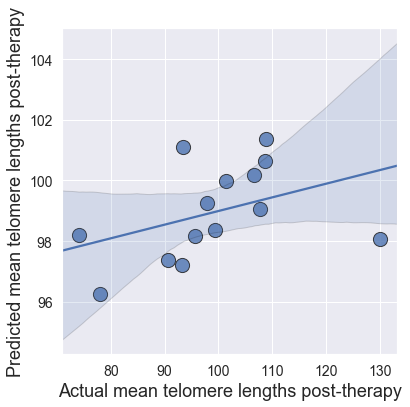

In [65]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [80]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [81]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')
quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,141.486033,372
1,1,2 irrad @ 4 Gy,52.792768,372
2,1,1 non irrad,96.082838,372
3,1,2 irrad @ 4 Gy,100.306259,372
4,1,1 non irrad,69.687151,372


## Train/test split 

In [86]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [84]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [85]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0, gamma=3)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [98]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Visualizing model objective

In [102]:
q_test_set.sort_values(by='patient id', ascending=True, inplace=True)
q_test_set.reset_index(drop=True, inplace=True)

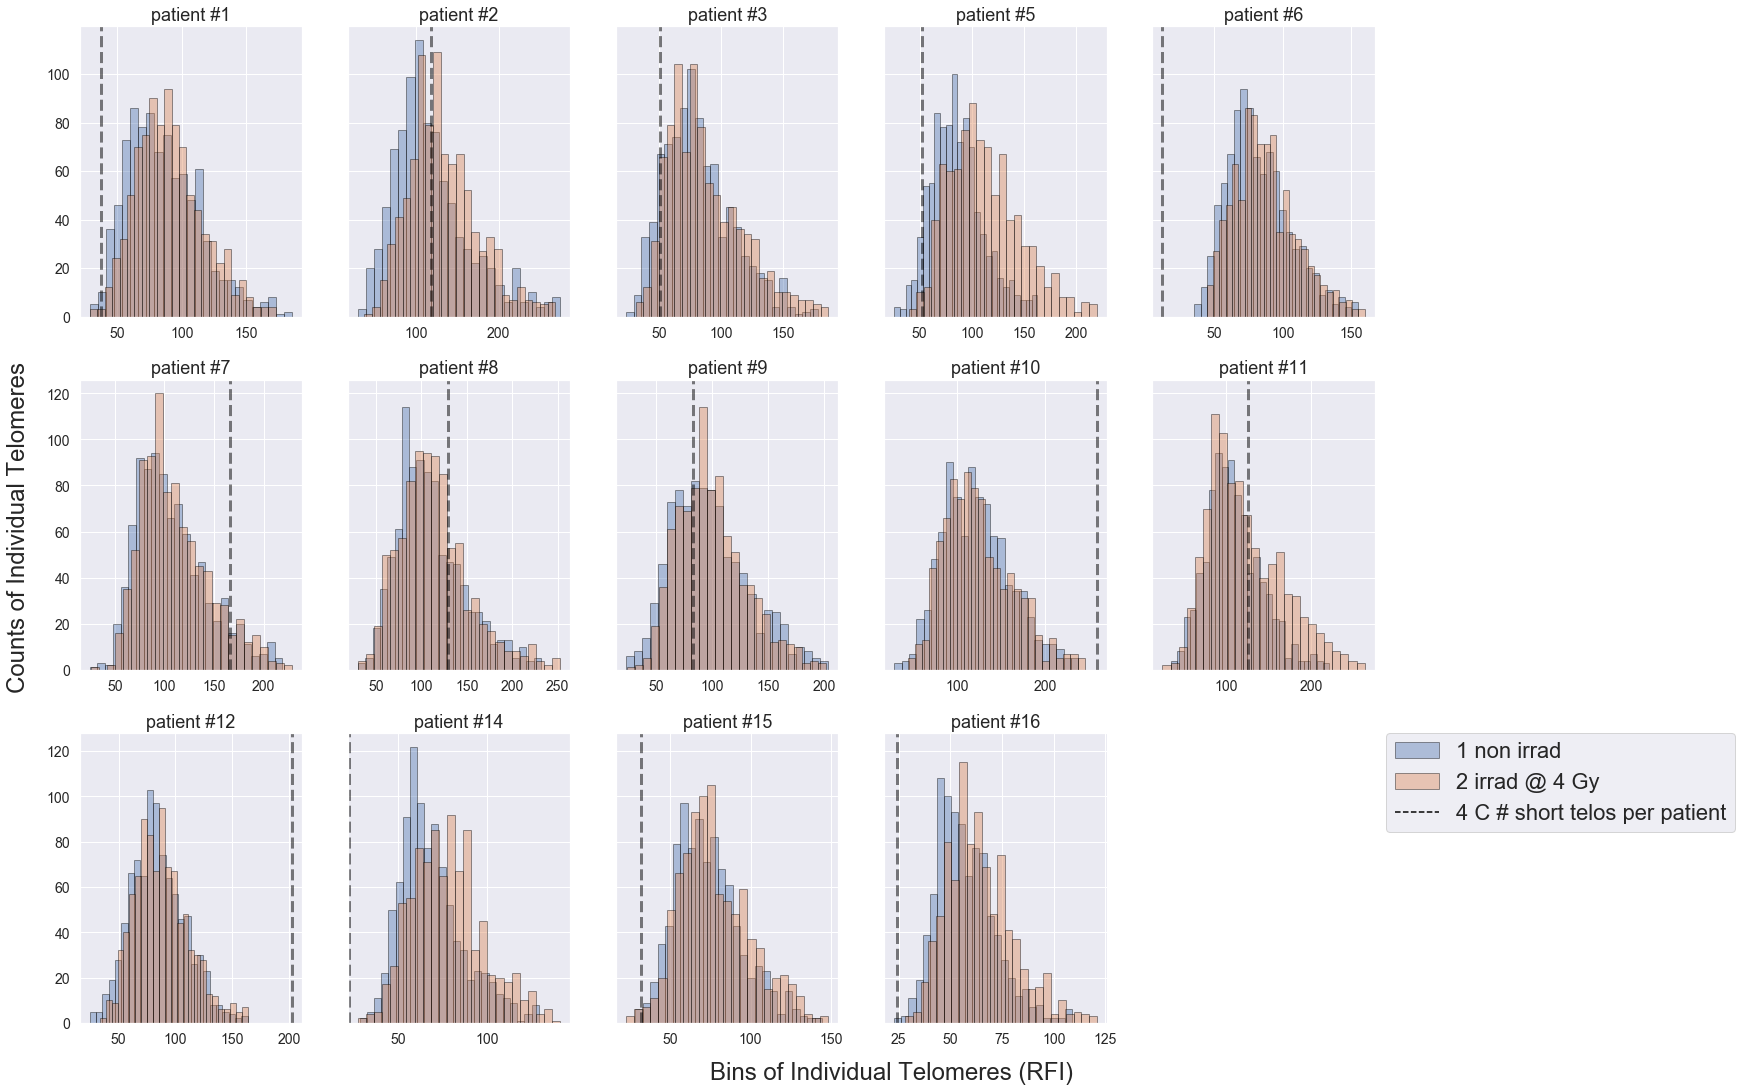

In [104]:
temp = q_test_set.copy()
temp['4 C # short telos'] = temp['4 C # short telos'] / 10
trp.plot_individ_telos_ML_objective(df=temp, target='4 C # short telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [64]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                                             model=q_model, cv=5, 
                                                             target='4 C # short telos')

MAE per CV fold: 
[228.52015469 235.17920168 235.9601429  232.8206818  236.18709705] 

MEAN of MAE all folds: 233.73345562330684
STD of MAE all folds: 2.8663683238410367

MAE of predict_y_test & y_test: 240.11503650238797
R2 between predict_y_test & y_test: 0.808524452659051


In [65]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 218.86515372140067
R2 predicted vs. actual 4 C # short telos: 0.8641850803855666


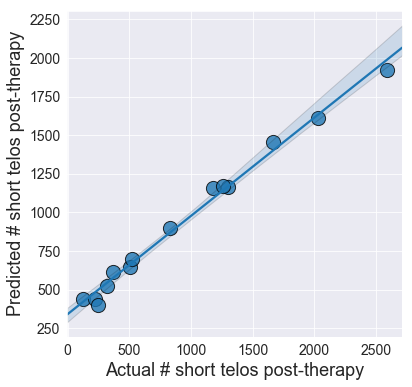

In [66]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=18)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # short telomeres vs predicted.png', 
            dpi=400)

## Dataframe for model metrics

In [88]:
telos_short_telos_rows = telo_row + short_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.2097,0.0578,3.1677,0.8922
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,233.7335,2.8664,240.1150,0.8085


In [89]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 # short telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [122]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [123]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [117]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=False, bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))
                                    ])

In [118]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,
                        )

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [119]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [90]:
bo_model = XGBRegressor(n_estimators=300, 
                        max_depth=10, 
                        learning_rate=0.2,
                        objective='reg:squarederror',
#                         colsample=.8897,
#                         gamma=3.185,
                        random_state=0,
                        )

In [92]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.12919167 0.08176287 0.14904422 0.08119349 0.15788098] 

MEAN of MAE all folds: 0.1198146451167558
STD of MAE all folds: 0.03265232944166446

MAE of predict_y_test & y_test: 0.2299969159066677
R2 between predict_y_test & y_test: -0.3298036219600655


In [93]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

MAE predicted vs. actual 4 C # inversions: 0.07870530329999484
R2 predicted vs. actual 4 C # inversions: -0.0872416453364313


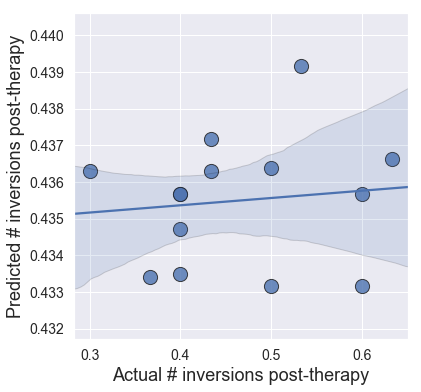

In [94]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=18)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)

## Looping through all aberrations for XGBoost model fitting, creating dataframes for graphing, displaying model metrics

In [81]:
features_list = [['# inversions'], ['# terminal inversions'], ['# translocations'], ['# dicentrics'],
                 ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']]

           
target1_list = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # terminal inversions', '4 C # translocations', '4 C # dicentrics',
                '4 C aberration index']

stats_list = []
stats_list, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                    target1_list=target1_list,
                                                                                    target2_list=target2_list,
                                                                                    stats_list=stats_list,
                                                                                    verbose=False)

--------------------------------------------------------------------
PERFORMING CROSSFOLD VALIDATION of XGBoost model
features: ['# inversions'] ___ target: 4 C # inversions
--------------------------------------------------------------------
MAE per CV fold: 
[0.12178751 0.06072514 0.09185666 0.09681536 0.11151848] 

MEAN of MAE all folds: 0.09654062909899394
STD of MAE all folds: 0.02081588361561253

MAE of predict_y_test & y_test: 0.28008289440047174
R2 between predict_y_test & y_test: -0.1194326039632112
--------------------------------------------------------------------
PREDICTIONS of trained XGBoost model vs. actual values
features: ['# inversions'] ___ target: 4 C # inversions
--------------------------------------------------------------------
MAE predicted vs. actual 4 C # inversions: 0.08535746690772843
R2 predicted vs. actual 4 C # inversions: -0.04140086683623778


--------------------------------------------------------------------
PERFORMING CROSSFOLD VALIDATION of XGBoo

## Dataframes & graphing model metrics & performance

In [101]:
graphing_df = trp.make_graphing_df(graphing_dict=graphing_dict)
stats_df = trp.make_stats_df(stats_list=stats_list)
display(stats_df)
path=f'../graphs/paper figures/supp figs/ML models predicting chr aberration types.png'
trp.df_to_png(df=stats_df, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[# inversions, timepoint_2 irrad @ 4 Gy]",4 C # inversions,0.0965,0.0208,0.2801,-0.1194
1,XGBoost,"[# terminal inversions, timepoint_2 irrad @ 4 Gy]",4 C # terminal inversions,0.0926,0.0324,0.1456,-0.0613
2,XGBoost,"[# translocations, timepoint_2 irrad @ 4 Gy]",4 C # translocations,0.0371,0.0055,0.1191,-0.0446
3,XGBoost,"[# dicentrics, timepoint_2 irrad @ 4 Gy]",4 C # dicentrics,0.1104,0.0383,0.1444,-0.0288
4,XGBoost,"[# inversions, # terminal inversions, # transl...",4 C aberration index,0.2662,0.0569,0.3385,-0.1794


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [98]:
# saving df of model metrics for all models
all_rows = telo_row + short_telos_row + stats_list
stats_df = trp.make_stats_df(stats_list=all_rows)

path=f'../graphs/paper figures/supp figs/ML models for all telo and chr aberr endpoints.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


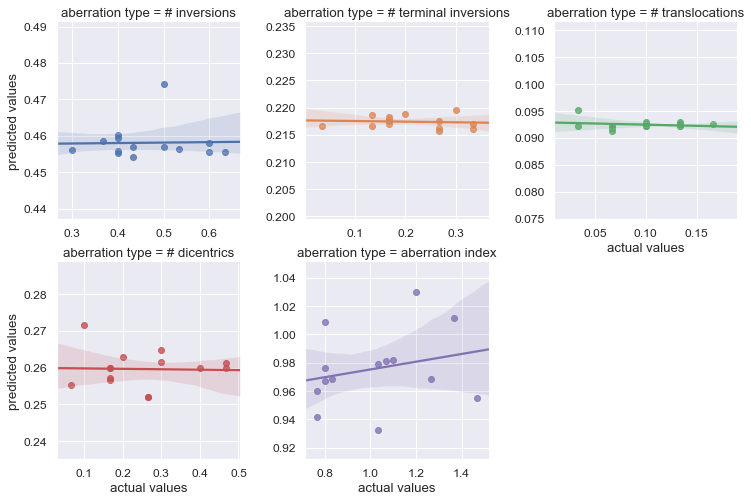

In [40]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='actual values', y='predicted values', col='aberration type', hue='aberration type', 
           sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.5)
plt.tight_layout(pad=.6)

# Clustering telomere data

## Mean telomere length (teloFISH)

In [44]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'Q1'], axis=1)

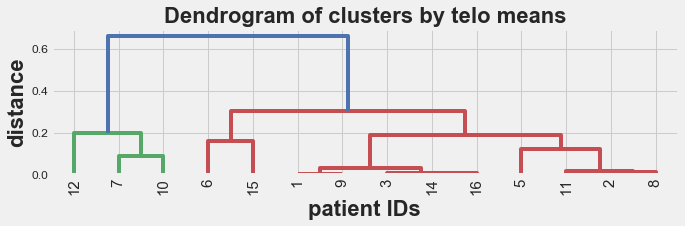

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


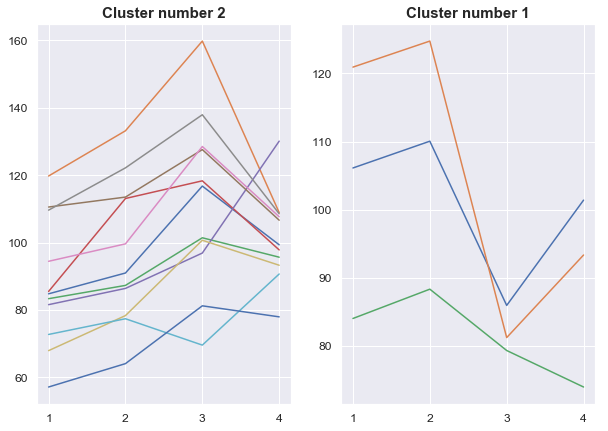

In [45]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             y_size=7)

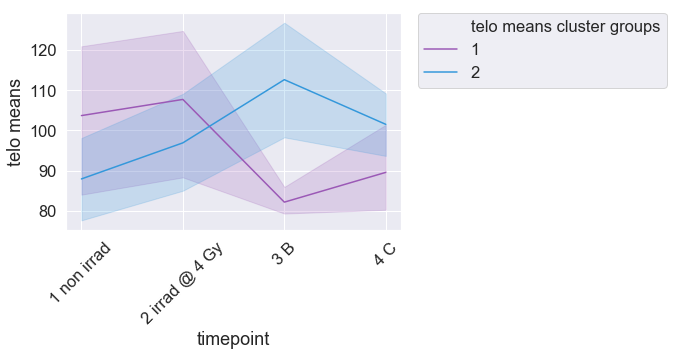

In [31]:
trp.graph_cluster_groups(clustered_telos, target='telo means', hue='telo means cluster groups')

telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


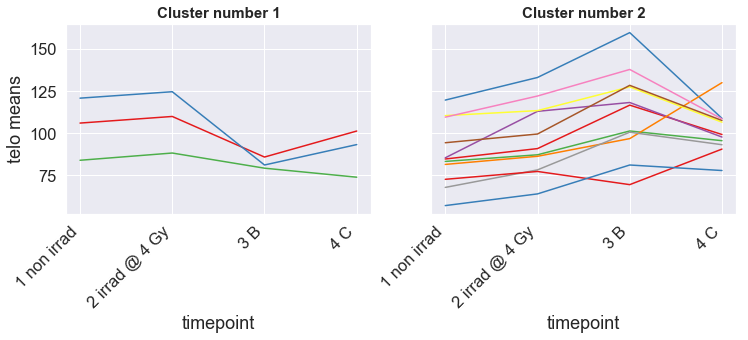

In [156]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [58]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': '# short telomeres'}, inplace=True)

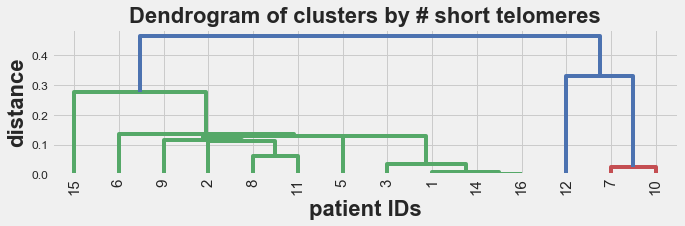

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


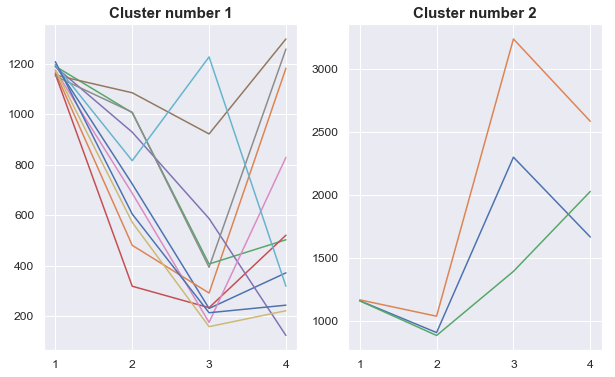

In [47]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='# short telomeres', cut_off_n=2)

In [71]:
clustered_short_telos.head()

,patient id,# short telomeres cluster groups,timepoint,# short telomeres
0,1,1,1 non irrad,1195
1,2,1,1 non irrad,1166
2,3,1,1 non irrad,1190
3,5,1,1 non irrad,1159
4,6,1,1 non irrad,1188


In [61]:
clustered_short_telos['# short telomeres cluster groups'] = (clustered_short_telos['# short telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

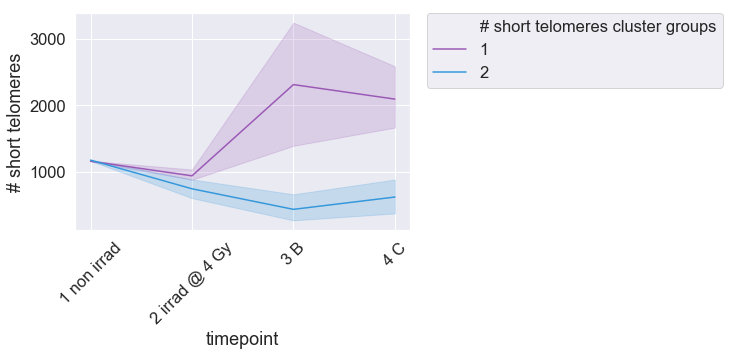

In [62]:
trp.graph_cluster_groups(clustered_short_telos, target='# short telomeres', hue='# short telomeres cluster groups')

# short telomeres CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]
# short telomeres CLUSTER 2 | patient IDs: [7, 10, 12]


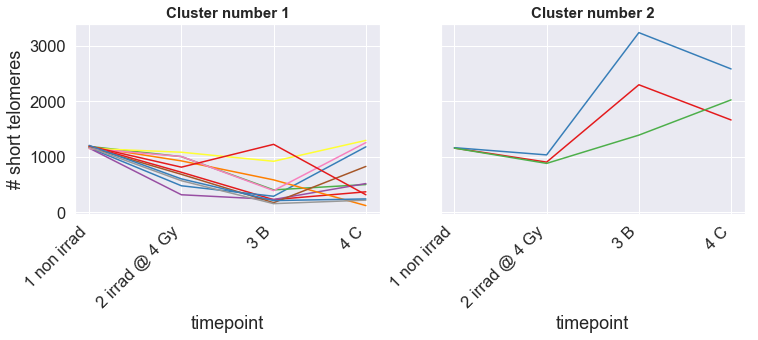

In [157]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Combining cluster groups of means + short telos

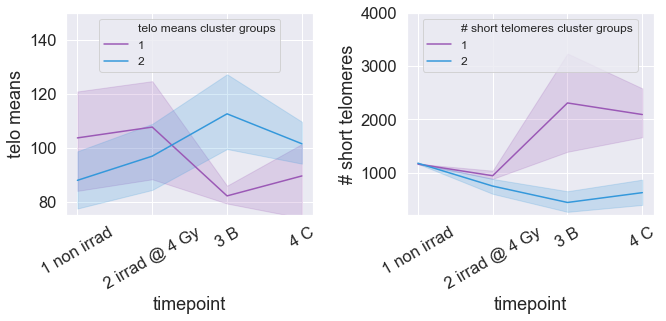

In [63]:
y_list = ['telo means', '# short telomeres']
hue_list = ['telo means cluster groups', '# short telomeres cluster groups']
df_list = [clustered_telos, clustered_short_telos]
ylim_dict = {'telo means': (75, 150),
             '# short telomeres': (200, 4000)}

trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

## Mean telomere length (qPCR)

In [158]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

,patient id,timepoint,telo means qPCR
0,1,1,2.182028
1,1,3,1.964348
2,1,4,1.749799
3,2,1,1.669445
4,2,3,1.780092


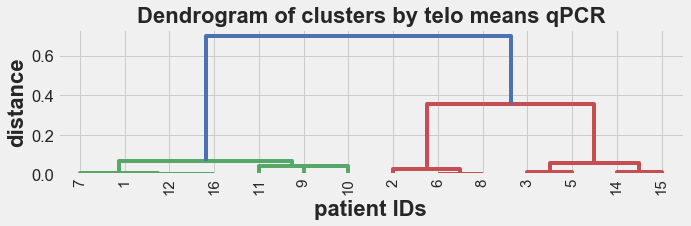

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


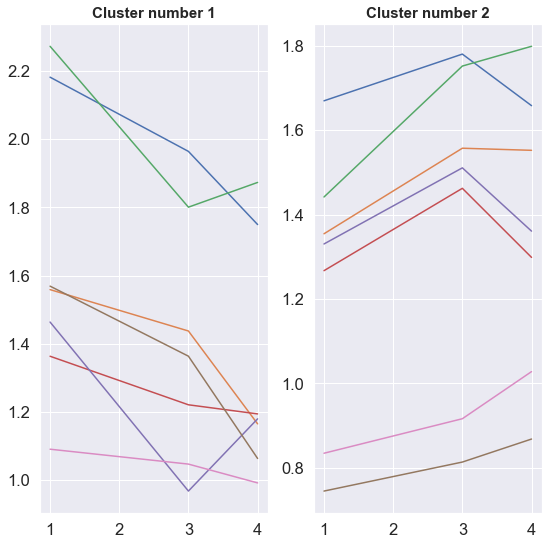

In [165]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

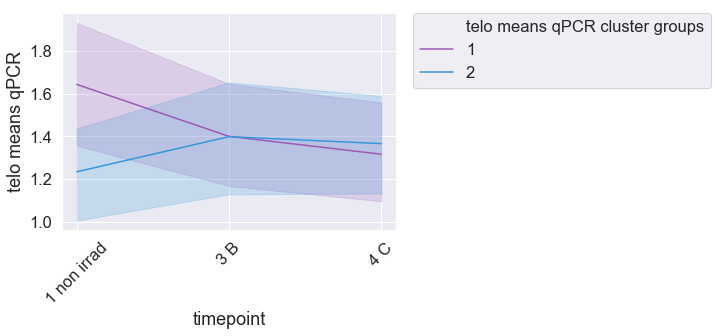

In [166]:
trp.graph_cluster_groups(clustered_qPCR, target='telo means qPCR', hue='telo means qPCR cluster groups')

# Clustering chromosome rearrangement data

In [3]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

## Inversions

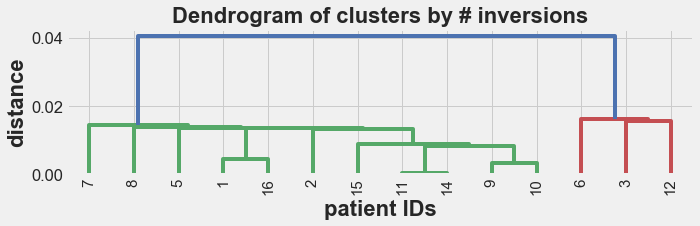

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


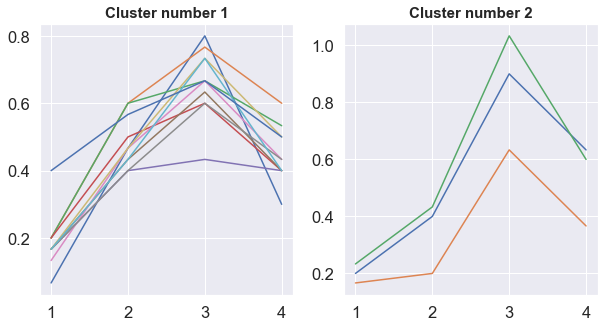

In [162]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

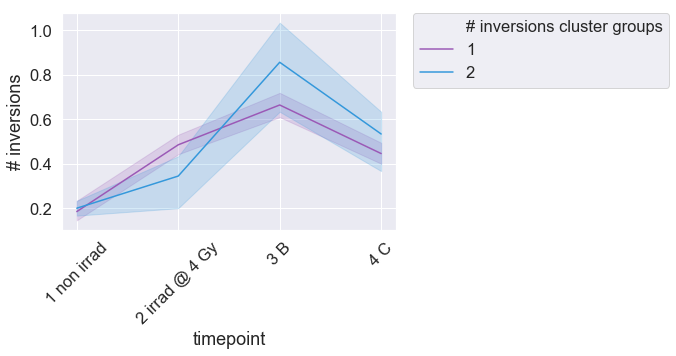

In [228]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 2, 5, 7, 8, 9, 10, 11, 14, 15, 16]
# inversions CLUSTER 2 | patient IDs: [3, 6, 12]


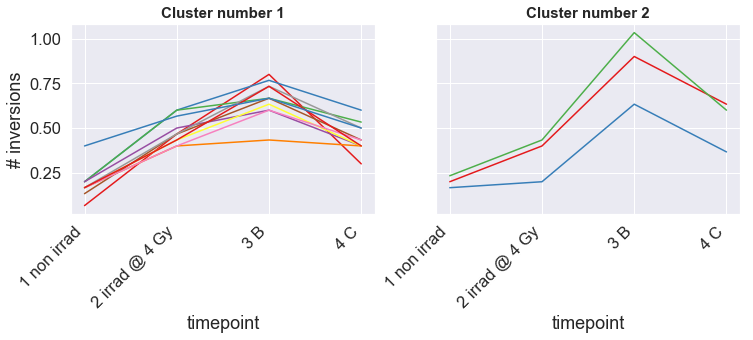

In [229]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Dicentrics

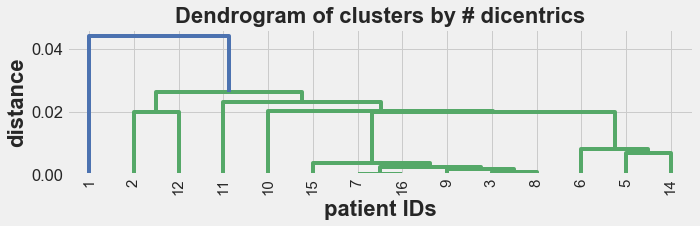

0 Cluster number 1 has 14 elements


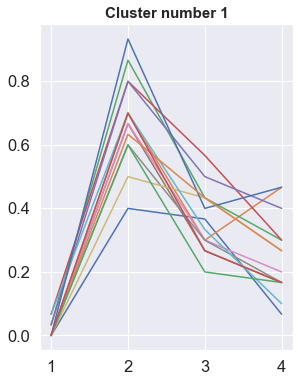

In [163]:
clustered_dicent = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1)

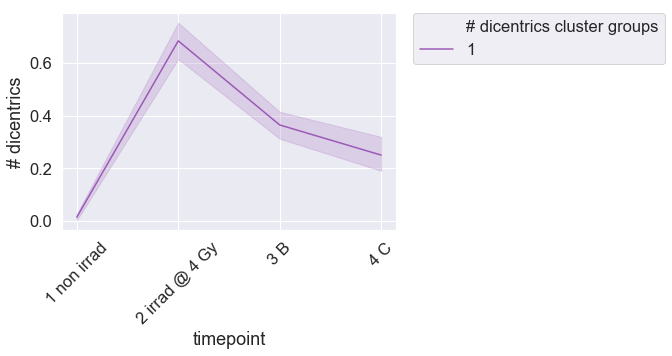

In [237]:
trp.graph_cluster_groups(clustered_dicent, target='# dicentrics', hue='# dicentrics cluster groups')

# dicentrics CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


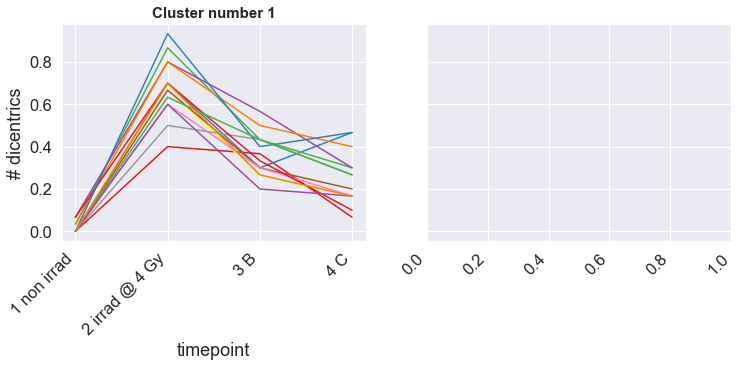

In [239]:
trp.graph_clusters_per_patient(clustered_dicent, target='# dicentrics', 
                               y_dimen=1, x_dimen=2, fsize=(12,4))

## Looping through all clustered groups graphs

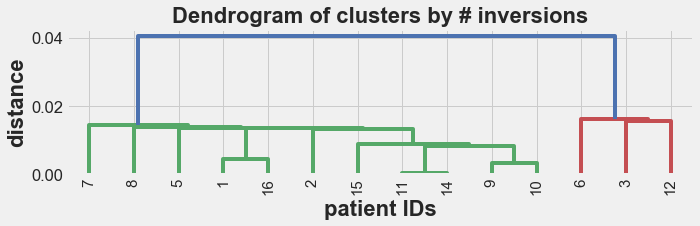

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


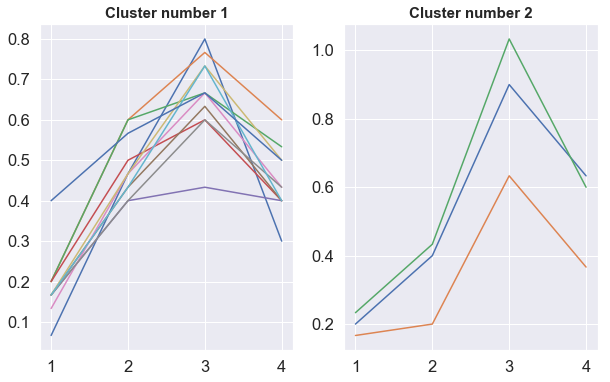

# inversions CLUSTER 1 | patient IDs: [1, 2, 5, 7, 8, 9, 10, 11, 14, 15, 16]
# inversions CLUSTER 2 | patient IDs: [3, 6, 12]


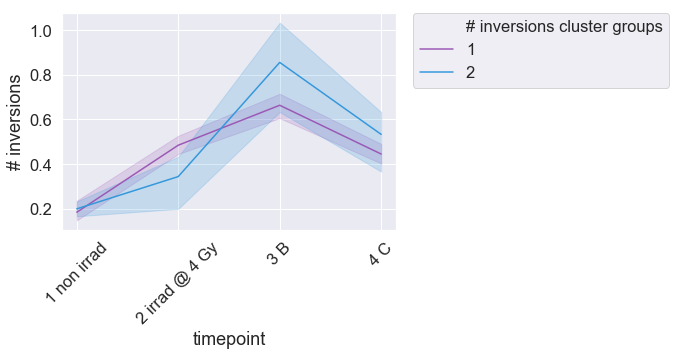

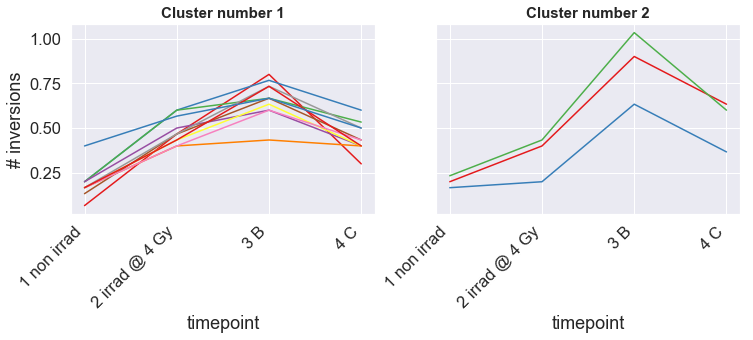

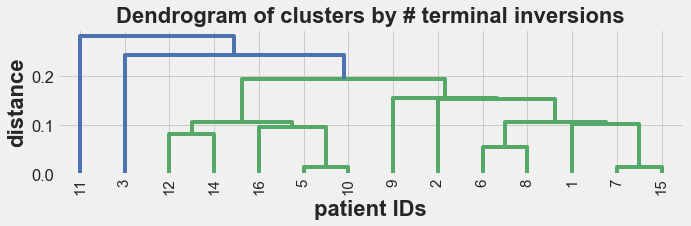

0 Cluster number 1 has 14 elements


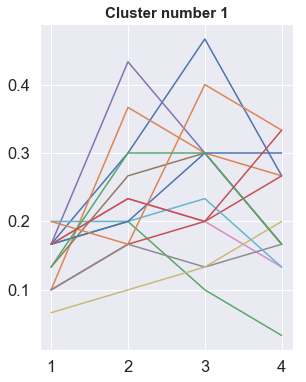

# terminal inversions CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


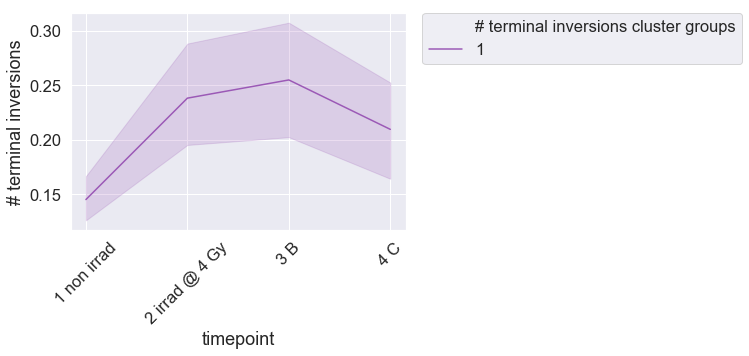

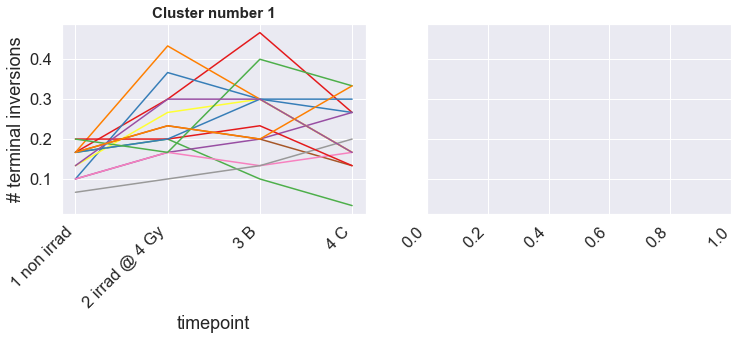

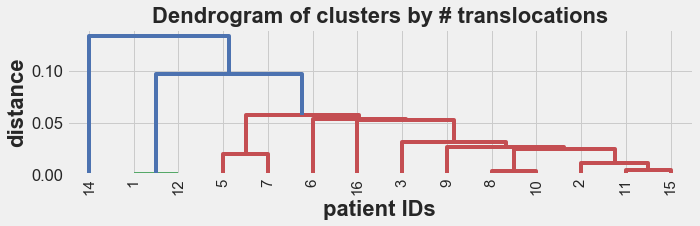

0 Cluster number 1 has 14 elements


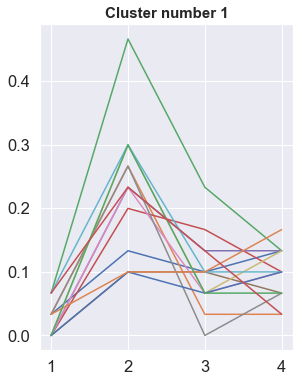

# translocations CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


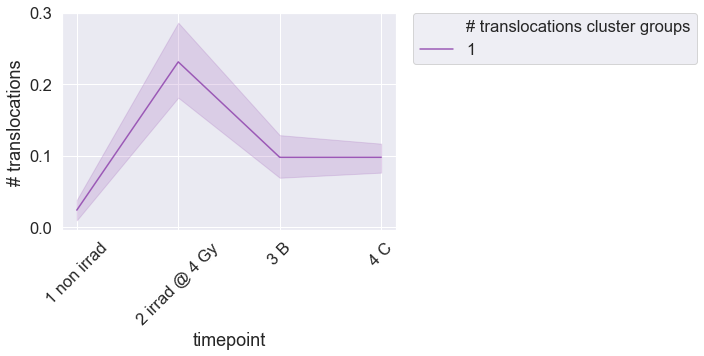

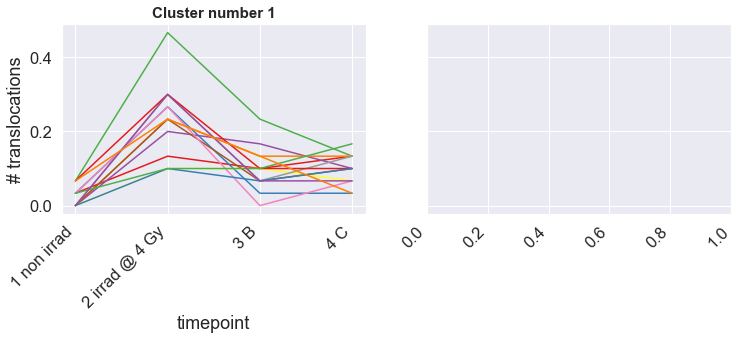

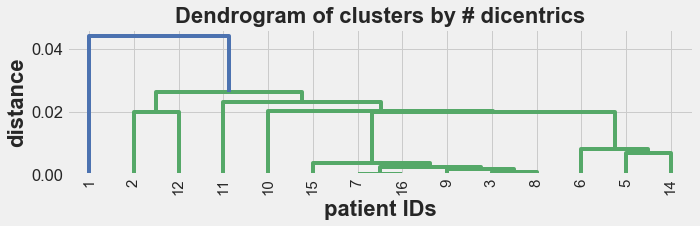

0 Cluster number 1 has 14 elements


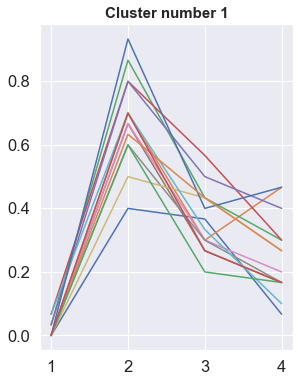

# dicentrics CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


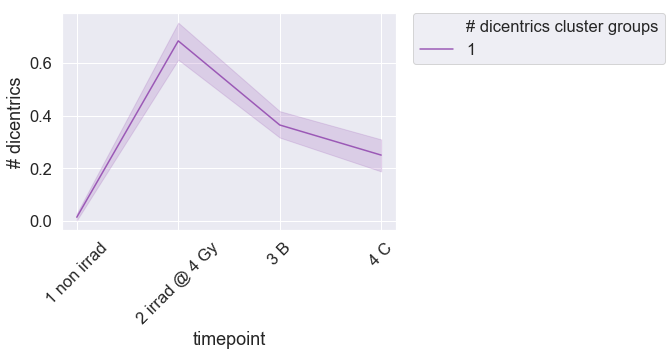

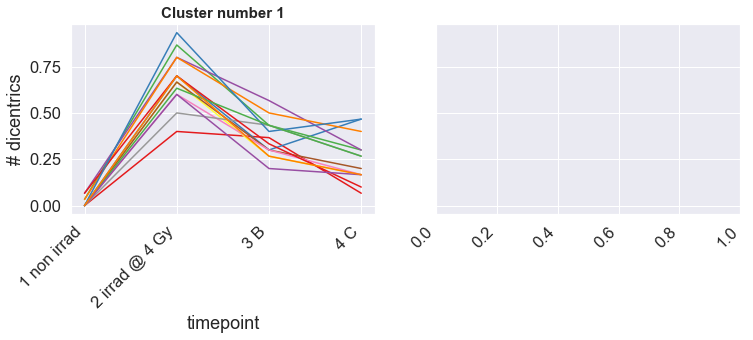

In [169]:
chr_aberr = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']

for target in chr_aberr:
    if target == '# inversions':
        n = 2
    else:
        n = 1
    clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=n)
    trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
    trp.graph_clusters_per_patient(clustered, target=target,
                                   y_dimen=1, x_dimen=2,
                                   fsize=(12,3.5))

In [170]:
def plot_multiple_types_clusters(y_list=None, hue_list=None,
                                 df_list=None, ylim_dict=None):
    
    fsize = (9.6, 4.8)
    
    if len(y_list) > 2:
        fsize = (9.6, 4.8)
        
    # define palette colorws & subplots
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    fig, ax = plt.subplots(1, 2, figsize=fsize, sharey=False, sharex='col')
    axes = ax.ravel()

    for ax_n, y, hue, df in zip(axes, y_list, hue_list, df_list):
        # creating plot
        sns.lineplot(x='timepoint', y=y, hue=hue, data=df, legend='full', ax=ax_n,
                    palette=sns.color_palette(flatui[:len(df[hue].unique())]),)

        # manipulating axes, legend
        plt.setp(ax_n.get_xticklabels(), rotation=30)
        ax_n.legend(fontsize=13, loc='upper center')
        ax_n.set_ylim(ylim_dict[y])
        sns.set(font_scale=1.5)
    plt.tight_layout()
        
    # save
#     if 'telo means' in y_list and '# short telomeres' in y_list:
#         plt.savefig(f'../graphs/paper figures/main figs/viz clustering groups {y_list[0]} and {y_list[1]}.png', 
#                     dpi=400, bbox_inches = "tight")
#     else:
#         plt.savefig(f'../graphs/paper figures/main figs/viz all chr aberrations.png', 
#                     dpi=400, bbox_inches = "tight")

## Graphing all aberration cluster groups at once

In [4]:
mean_chr['aberration index'] = (mean_chr['# inversions'] + mean_chr['# terminal inversions'] +
                                mean_chr['# translocations'] + mean_chr['# dicentrics'])

In [5]:
# initializing list of aberrations to cluster by
y_list = ['# inversions', 
          '# terminal inversions', 
          '# translocations', 
          '# dicentrics', 
          'aberration index']

# initializing list of dfs bearing clustered groups
inv_df = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2, verbose=False)
term_inv_df = trp.cluster_data_return_df(mean_chr, target='# terminal inversions', cut_off_n=1, verbose=False)
trans_df = trp.cluster_data_return_df(mean_chr, target='# translocations', cut_off_n=1, verbose=False)
dicent_df = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1, verbose=False)
aberr_index_df = trp.cluster_data_return_df(mean_chr, target='aberration index', cut_off_n=1, verbose=False)

df_list = [inv_df, 
           term_inv_df,
           trans_df, 
           dicent_df,
           aberr_index_df]

# hues to graph by
hue_list = ['# inversions cluster groups', 
            '# terminal inversions cluster groups', 
            '# translocations cluster groups', 
            '# dicentrics cluster groups', 
            'aberration index cluster groups']

# dimensions for each aberration
ylim_dict = {'# inversions': (.1, 1.4),
             '# terminal inversions': (.1, .4),
             '# translocations': (0, .35),
             '# dicentrics': (0, 1),
             'aberration index': (.2, 2.2)}

In [42]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


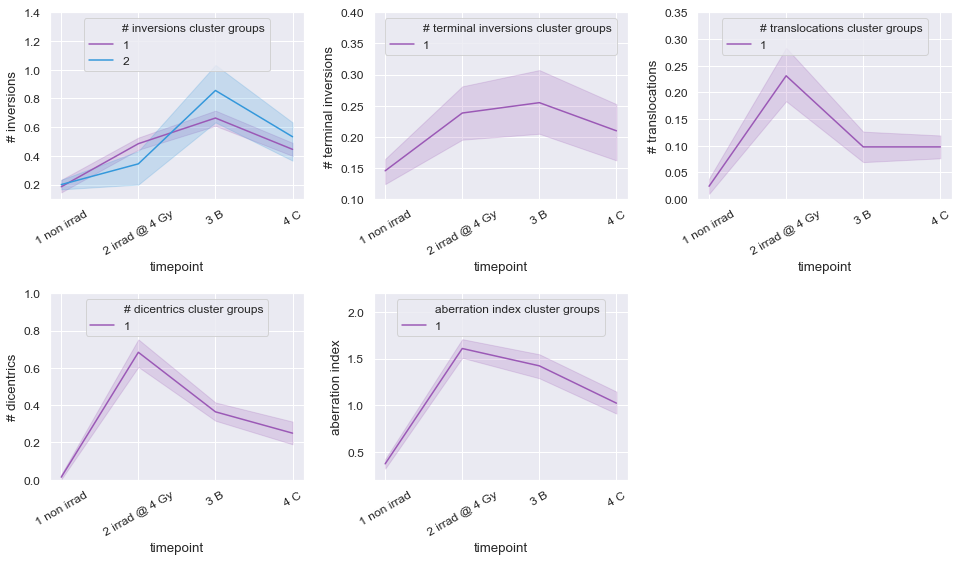

In [43]:
trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)